<a href="https://colab.research.google.com/github/sholtodouglas/artificial_graphics/blob/main/artificial_graphics_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku
!git clone https://github.com/kingoflolz/DALL-E-JAX
% cd DALL-E-JAX/
! pip install -e .


In [6]:
!wget https://cdn.openai.com/dall-e/encoder.pkl
!wget https://cdn.openai.com/dall-e/decoder.pkl

--2021-04-21 11:30:30--  https://cdn.openai.com/dall-e/encoder.pkl
Resolving cdn.openai.com (cdn.openai.com)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::38, ...
Connecting to cdn.openai.com (cdn.openai.com)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215185363 (205M) [application/octet-stream]
Saving to: ‘encoder.pkl’

encoder.pkl         100%[===================>] 205.22M  15.0MB/s    in 13s     

2021-04-21 11:30:44 (15.5 MB/s) - ‘encoder.pkl’ saved [215185363/215185363]

--2021-04-21 11:30:44--  https://cdn.openai.com/dall-e/decoder.pkl
Resolving cdn.openai.com (cdn.openai.com)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::38, ...
Connecting to cdn.openai.com (cdn.openai.com)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175360231 (167M) [application/octet-stream]
Saving to: ‘decoder.pkl’

decoder.pkl         100%[===================>] 167.24M  24.2MB/s    in 8.3s    

2021-04-21 11:30:52 (20.2

In [2]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [18]:
  
import io

import jax
import requests
import PIL
from PIL import ImageOps

import numpy as np
import jax.numpy as jnp

from dall_e_jax import get_encoder, get_decoder, map_pixels, unmap_pixels

target_image_size = 256


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img):
    img = ImageOps.fit(img, [target_image_size,] * 2, method=0, bleed=0.0, centering=(0.5, 0.5))

    img = np.expand_dims(np.transpose(np.array(img).astype(np.float32)/255, (2, 0, 1)), 0)
    return map_pixels(img)


jax_enc_fn, jax_enc_params = get_encoder("encoder.pkl")
jax_dec_fn, jax_dec_params = get_decoder("decoder.pkl")



In [21]:
x = preprocess(download_image('https://cdn.slidemodel.com/wp-content/uploads/FF0127-01-process-flow-slide-for-powerpoint-16x9-2.jpg'))

z_logits = jax_enc_fn(jax_enc_params, x)

z = jnp.argmax(z_logits, axis=1)
z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))

x_stats = jax_dec_fn(jax_dec_params, z)

x_rec = unmap_pixels(jax.nn.sigmoid(x_stats[:, :3]))
x_rec = np.transpose((np.array(x_rec[0]) * 255).astype(np.uint8), (1, 2, 0))

PIL.Image.fromarray(x_rec).save('reconstructed.png')

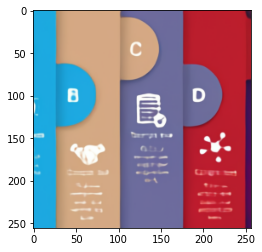

In [22]:
import matplotlib.pyplot as plt
plt.imshow(x_rec)